In [3]:
import sys
from os import path
sys.path.append(path.dirname(path.dirname(path.abspath('model.py'))))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
import model

In [30]:
from importlib import reload
reload(model);

# Load training data

In [16]:
# Load train data
TRAIN_PATH = '../../data/train_data.pkl'
train_noisy_imgs_input, train_noisy_imgs_target = torch.load(TRAIN_PATH)
train_noisy_imgs_input = train_noisy_imgs_input
train_noisy_imgs_target = train_noisy_imgs_target
print('training size: ', train_noisy_imgs_input.shape[0])
training_set_size, num_channels, y_size, x_size = train_noisy_imgs_input.shape

training size:  50000


In [7]:
# Load validation data
VALIDATION_PATH = '../../data/val_data.pkl'
validation_noisy_imgs, validation_clean_imgs = torch.load(VALIDATION_PATH)
validation_noisy_imgs = validation_noisy_imgs
validation_clean_imgs = validation_clean_imgs
print('validation size: ', validation_clean_imgs.shape[0])

validation size:  1000


## Our implementation

In [25]:
train_noisy_imgs_input.dtype

torch.uint8

In [10]:
ourModel = model.Model()
ourModel.train(train_noisy_imgs_input, train_noisy_imgs_target, num_epochs=10, debug=True)

RuntimeError: result type Float can't be cast to the desired output type Byte

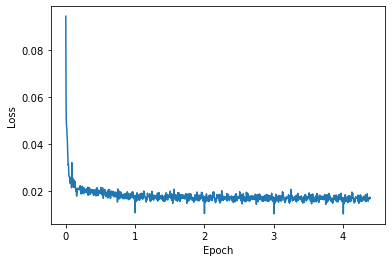

In [114]:
fig = plt.figure()
xs = np.arange(len(ourModel.losses)) / train_noisy_imgs_input.shape[0] * 32 * 5
plt.plot(xs, ourModel.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

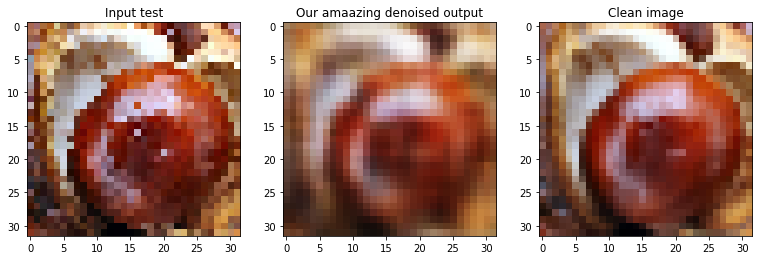

In [115]:
test_input = validation_noisy_imgs
test_target = validation_clean_imgs

nr = 3
denoised = ourModel.predict(test_input[nr, :, :, :].unsqueeze(dim=0))

fig, ax = plt.subplots(1, 3, figsize=(13,5))
ax[0].imshow(test_input[nr,:,:,:].permute(1,2,0).cpu(), cmap='gray')
ax[0].set_title('Input test')
ax[1].imshow(denoised[0,:,:,:].permute(1,2,0).cpu().detach().numpy(), cmap='gray')
ax[1].set_title('Our amaazing denoised output')
ax[2].imshow(test_target[nr, :, :, :].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Clean image')
plt.show()

In [44]:
def evaluate(denoised, target):
    mse = torch.mean((denoised - target) ** 2)
    return -10 * torch.log10(mse + 10**-8)

def evaluate_correct(denoised, target):
    mse = ((denoised - target) ** 2).mean((1, 2, 3))
    return -10 * torch.log10(mse + 10**-8).mean()

In [118]:
denoised = ourModel.predict(test_input)
evaluate(denoised, test_target)

tensor(22.3254)

In [ ]:
torch.save(ourModel.model, 'bestmodel.pt')

## Torch implementation

In [55]:
class TorchModel():
    def __init__(self, **kwargs):
        self.model = nn.Sequential(nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 3, 3, padding=1),
            nn.Sigmoid()
            )
        self.criterion = nn.MSELoss()

        optimizer = kwargs.get('optimizer', 'Adam')
        if(optimizer == 'Adam'):
            self.optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-2)
        elif(optimizer == 'SGD'):
            self.optimizer = torch.optim.SGD(torch_model.parameters(), lr=1)
        else:
            raise ValueError('Optimizer not implemented')

    def load_pretrained_model(self):
        ## This loads the parameters saved in bestmodel.pth into the model
        self.model = load('bestmodel.pth')

    def train(self, train_input, train_target, num_epochs, **kwargs):
        # train ̇input: tensor of size (N, C, H, W) containing a noisy version of the images.
        # train target: tensor of size (N, C, H, W) containing another noisy version of the
        # same images, which only differs from the input by their noise.
        train_input = train_input / 255.0
        train_target = train_target / 255.0
        batch_size = kwargs.get('batch_size', 32)
        self.losses = []
        avg_loss = 0
        
        for e in range(num_epochs):
            print('Doing epoch %d'%e)
            for b, (input, target) in enumerate(zip(train_input.split(batch_size),
                                                    train_target.split(batch_size))):
                output = self.model(input)
                loss = self.criterion(output, target)
                avg_loss += loss.item()

                # make step
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                b_freq = 5
                if b % b_freq == 0 and (b+e) > 0:
                    self.losses.append(avg_loss / b_freq)
                    avg_loss = 0
                    b % 50 == 0 and print(self.losses[-1])

    def predict(self, test_input):
        #:test ̇input: tensor of size (N1, C, H, W) that has to be denoised by the trained
        # or the loaded network.
        #: returns a tensor of the size (N1, C, H, W)
        return self.model(test_input / 255.0) * 255.0

In [54]:
summary(TorchModel().model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
              ReLU-4             [-1, 32, 8, 8]               0
          Upsample-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 16, 16, 16]           4,624
              ReLU-7           [-1, 16, 16, 16]               0
          Upsample-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 3, 32, 32]             435
          Sigmoid-10            [-1, 3, 32, 32]               0
Total params: 10,147
Trainable params: 10,147
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.39
Params size (MB): 0.04
Estimated Tot

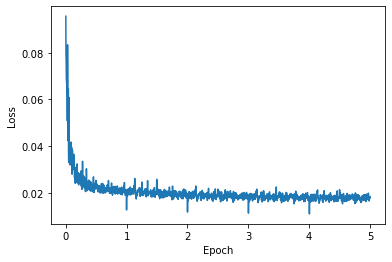

In [49]:
fig = plt.figure()
xs = np.arange(len(losses)) / train_noisy_imgs_input.shape[0] * 32 * 5
plt.plot(xs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

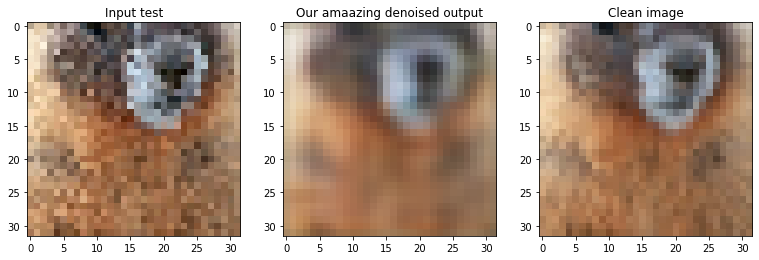

In [50]:
test_input = validation_noisy_imgs / 255.0
test_target = validation_clean_imgs / 255.0

nr = 1
denoised = torch_model(test_input[nr, :, :, :].unsqueeze(dim=0))

fig, ax = plt.subplots(1, 3, figsize=(13,5))
ax[0].imshow(test_input[nr,:,:,:].permute(1,2,0).cpu(), cmap='gray')
ax[0].set_title('Input test')
ax[1].imshow(denoised[0,:,:,:].permute(1,2,0).cpu().detach().numpy(), cmap='gray')
ax[1].set_title('Our amaazing denoised output')
ax[2].imshow(test_target[nr,:,:,:].permute(1,2,0).cpu(), cmap='gray')
ax[2].set_title('Clean image')
plt.show()

In [ ]:
# Visualize predictions
example_image_nrs = [10, 732, 880] #[10, 888, 83]
nr_example_images = 3
model_list = ['Torch']

fig, ax = plt.subplots(nr_example_images, len(model_list)+2, figsize=(5.5, 4))
random_nrs = torch.randint(validation_noisy_imgs.shape[0], size=(1, nr_example_images))

for m in range(len(model_list)):
  net = set_model(model_list[m])
  for i in range(nr_example_images):

    nr = example_image_nrs[i]
    denoised = net.predict(validation_noisy_imgs[nr,:,:,:].unsqueeze(dim=0))
    dB = net.evaluate(denoised, validation_clean_imgs[nr,:,:,:])

    ax[i,m+1].imshow(denoised[0,:,:,:].permute(1,2,0).detach().cpu())
    (i==0) and ax[i,m+1].set_title(model_list[m])
    ax[i,m+1].axis('off')
    ax[i,m+1].text(23,30,f'%.2f dB'%(dB.item()), ha='center', va='center', 
                   color='w', backgroundcolor='k', fontsize='small',
                   bbox=dict(alpha=0.6, color='k'))

    if (m==0):
      ax[i,0].imshow(validation_noisy_imgs[nr,:,:,:].permute(1,2,0).cpu())
      (i==0) and ax[i,0].set_title('Input')
      ax[i,0].axis('off')

      ax[i,len(model_list)+1].imshow(validation_clean_imgs[nr,:,:,:].permute(1,2,0).cpu())
      (i==0) and ax[i,len(model_list)+1].set_title('Target')
      ax[i,len(model_list)+1].axis('off')

#fig.tight_layout()
fig.savefig('/content/drive/MyDrive/Proj_338157_338681_311699/Miniproject_1/Figures/example_outputs.pdf')

In [51]:
denoised = torch_model(test_input)
evaluate(denoised, test_target)

tensor(21.8604, grad_fn=<MulBackward0>)

In [52]:
evaluate_correct(denoised, test_target)

tensor(22.5249, grad_fn=<MulBackward0>)

## Evaluation

In [ ]:
def set_model(model_name):
  if (model_name=='Ours'):
    net = model.Model(optimizer='Adam')
    filename = 'OurModel.pth'
  elif (model_name=='Ours_SGD'):
    net = model.Model(optimizer='SGD')
    filename = 'OurModel_SGD.pth'
  elif (model_name=='Torch'):
    net = model.Model(optimizer='Adam')
    filename = 'Torch.pth'
  else:
    raise ValueError('Invalid model name!')

  net.load_pretrained_model(filename)